安装mindspore、mindvision(已解耦)

https://www.mindspore.cn/install

https://mindspore.cn/vision/docs/zh-CN/r0.1/mindvision_install.html

In [1]:
import mindspore
mindspore.run_check()

MindSpore version:  1.8.1
The result of multiplication calculation is correct, MindSpore has been installed successfully!


In [2]:
import os
import os.path as osp
import time
import numpy as np
import re
import glob
from PIL import Image

import mindspore.nn as nn
import mindspore.ops as ops
from matplotlib import pyplot as plt
from mindspore.common import set_seed
from mindspore import Tensor, Model, context
from mindspore import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, \
    TimeMonitor, SummaryCollector
import mindspore.dataset as ds
from mindspore.dataset.vision import Resize, Rescale, Normalize, HWC2CHW, RandomHorizontalFlip, RandomErasing
from mindspore.dataset.transforms import Compose
from mindspore.common.initializer import initializer, HeNormal
from collections import OrderedDict

# OSNet行人重识别

## 任务简介

![reid.png](./img/reid.png)

行人重识别是利用计算机视觉技术判断图像或者视频序列中是否存在特定行人的技术，通常被认为是一个图像检索的子问题。在监控视频中，由于相机分辨率和拍摄角度的缘故，通常无法得到高质量的人脸图片。当人脸识别失效的情况下，ReID就成为了人物身份识别的重要替代技术。
行人重识别的数据集通常是通过人工标注或者检测算法得到的行人图片。数据集分为训练集、验证集、Query、Gallery。在训练集上进行训练得到的模型对Query与Gallery中的图片分别提取特征并计算相似度。对于每个Query，在Gallery中会找出前N个与其相似的图片。训练、测试中人物身份不重复。

## OSNet简介

![schematic](./img/schematic.png)

首先需要理解omni-scale指什么？ReID任务是一个实例层面的识别任务，非常依赖模型能学习判别性特征，提取判别性特征需要多尺度，文中解释为是全方位的的同质性和异质性的特征。

OSNet有三点主要设计：
1. 改进传统卷积，减少模型参数量
2. 改进残差块，增加多个分支来学习不同尺度特征
3. 设计了一个多分支动态融合模块，融合不同尺度特征

总的来说，OSNet拥有学习全尺度特征的能力，同时又使用了非常轻量化的设计。

下面具体解析每个部分：

## 模型解析

### LightConv3x3
![](./img/LightConv.png)
（a）为常规的3\*3卷积ReLU(w∗x)。举个例子，如下图所示，原本三个通道的输入，经过一个包含4个Filter的卷积层，最终输出4个Feature Map，此时，卷积层共4个Filter，每个Filter包含了3个Kernel，每个Kernel的大小为3×3。因此卷积层的参数数量可以用如下公式来计算：N_std = 4 × 3 × 3 × 3 = 108
![](./img/conv3.png)
（b）为轻量化的。思想是采用point-wise和depth-wise的卷积方式拆分常规的卷积为两步，来减少参数量和运算量。

#### Depth-wise 卷积
![](./img/depthwise.png)
每个通道分别做卷积，通道数量不发生变化，卷积核数量和通道数相等。此时参数量为：N_depthwise = 3 × 3 × 3 = 27

#### Point-wise 卷积
![](./img/pointwise.png)
相当于卷积核尺寸为1\*1的常规卷积，在深度上做加权计算。参数量为：N_pointwise = 1 × 1 × 3 × 4 = 12

可以看到，将一个常规卷积分解为上两者的组合，可以看到参数上减少到1/3左右。本文这里稍有不同，先做point-wise卷积后做depth-wise卷积，原理一样。


In [3]:
def kaiming_normal(shape, mode='fan_out', nonlinearity='relu'):
    weight = initializer(HeNormal(mode=mode, nonlinearity=nonlinearity), shape=shape)
    return weight

def _conv2d(in_channels, out_channels, kernel_size, stride, pad_mode, padding, group=1, has_bias=False):
    weight_shape = [out_channels, in_channels//group, kernel_size, kernel_size]
    weight = kaiming_normal(weight_shape)
    conv = nn.Conv2d(in_channels=in_channels,
                     out_channels=out_channels,
                     kernel_size=kernel_size,
                     stride=stride,
                     pad_mode=pad_mode,
                     padding=padding,
                     group=group,
                     has_bias=has_bias,
                     weight_init=weight
                     )
    return conv

class LightConv3x3(nn.Cell):
    def __init__(self, in_channels, out_channels):
        super(LightConv3x3, self).__init__()
        self.conv1 = _conv2d(in_channels, out_channels, 1, stride=1, pad_mode='valid', padding=0)
        self.conv2 = _conv2d(out_channels, out_channels, 3, stride=1, pad_mode='pad', padding=1, group=out_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

### OSBlock中的ChannelGate

![](./img/osblock.png)

OSBlock有多个分支，每个分支都可以提供特定尺度的特征，为了学习全尺度特征，以动态的方式融合不同分支的输出，动态的多尺度融合通过一个mini-network（虚线框内）来自动学习权重向量，不固定权重，也不简单等权重融合，而是可学习的权重，这样的方法更精细。这是用一个由非参数全局平均池化层和多层感知器（MLP）组成的小型网络，其中有一个ReLU激活的隐藏层，最后是sigmoid激活。多个分支之间参数是共享的。

In [4]:
class ChannelGate(nn.Cell):
    def __init__(
            self,
            in_channels,
            num_gates=None,
            return_gates=False,
            gate_activation='sigmoid',
            reduction=16,
    ):
        super(ChannelGate, self).__init__()
        if num_gates is None:
            num_gates = in_channels
        self.return_gates = return_gates
        self.global_avgpool = ops.ReduceMean(keep_dims=True)
        self.fc1 = _conv2d(in_channels, in_channels//reduction, kernel_size=1, stride=1,
                           pad_mode='valid', padding=0, has_bias=True)
        self.relu = nn.ReLU()
        self.fc2 = _conv2d(in_channels//reduction, num_gates, kernel_size=1, stride=1,
                           pad_mode='valid', padding=0, has_bias=True)
        if gate_activation == 'sigmoid':
            self.gate_activation = nn.Sigmoid()
        elif gate_activation == 'relu':
            self.gate_activation = nn.ReLU()
        elif gate_activation == 'linear':
            self.gate_activation = None

    def construct(self, x):
        inputs = x
        x = self.global_avgpool(x, (2, 3))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        if self.gate_activation is not None:
            x = self.gate_activation(x)
        if self.return_gates:
            return x
        return inputs * x

### OSBlock（bottleneck）

参考resnet残差块，将卷积层替换为LightConv3x3。（a）是一个优化卷积后常规的残差快。（b）是多个分支的结构，每个分支学习不同尺度的特征，通过堆叠LightConv3x3来实现获取不同大小感受野，堆叠层数越多，感受野越大。注意，这里的1×1层是用来操作特征维度的，对空间信息的聚合没有贡献。不同的分支学习的特征，通过上述融合模块Unified  aggregation  gate，学习一个权重参数，加权融合成一个特征。值得一提的是，这里的权重不仅是动态可学习的，还是一个向量，维度和通道数相同，而不是一个标量。

In [5]:
class Conv1x1(nn.Cell):
    def __init__(self, in_channels, out_channels, stride=1, group=1):
        super(Conv1x1, self).__init__()
        self.conv = _conv2d(in_channels, out_channels, 1, stride=stride, pad_mode='valid', padding=0, group=group)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Conv1x1Linear(nn.Cell):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Conv1x1Linear, self).__init__()
        self.conv = _conv2d(in_channels, out_channels, 1, stride, pad_mode='valid', padding=0)
        self.bn = nn.BatchNorm2d(out_channels)

    def construct(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x
    
    
class OSBlock(nn.Cell):
    def __init__(
            self,
            in_channels,
            out_channels,
            bottleneck_reduction=4,
            **kwargs
    ):
        super(OSBlock, self).__init__()
        mid_channels = out_channels // bottleneck_reduction
        self.conv1 = Conv1x1(in_channels, mid_channels)
        self.conv2a = LightConv3x3(mid_channels, mid_channels)
        self.conv2b = nn.SequentialCell(
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
        )
        self.conv2c = nn.SequentialCell(
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
        )
        self.conv2d = nn.SequentialCell(
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
        )
        self.gate = ChannelGate(mid_channels)
        self.conv3 = Conv1x1Linear(mid_channels, out_channels)
        self.downsample = None
        self.relu = nn.ReLU()
        if in_channels != out_channels:
            self.downsample = Conv1x1Linear(in_channels, out_channels)

    def construct(self, x):
        identity = x
        x1 = self.conv1(x)
        x2a = self.conv2a(x1)
        x2b = self.conv2b(x1)
        x2c = self.conv2c(x1)
        x2d = self.conv2d(x1)
        x2 = self.gate(x2a) + self.gate(x2b) + self.gate(x2c) + self.gate(x2d)
        x3 = self.conv3(x2)
        if self.downsample is not None:
            identity = self.downsample(identity)
        add = x3 + identity
        out = self.relu(add)
        return out

### OSNet

![](./img/Architecture.png)

OSNet是通过简单地逐层堆叠OSBlock构建，没有煞费苦心的去设计，上图为网络架构。

In [6]:
class ConvLayer(nn.Cell):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size=7,
            stride=2,
            pad_mode='pad',
            padding=3,
            group=1,
            has_bias=False
    ):
        super(ConvLayer, self).__init__()
        self.conv = _conv2d(in_channels, out_channels, kernel_size,
                            stride, pad_mode, padding, group, has_bias)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class OSNet(nn.Cell):
    def __init__(
            self,
            num_classes,
            blocks,
            layers,
            channels,
            feature_dim=512,
            **kwargs
    ):
        super(OSNet, self).__init__()
        num_blocks = len(blocks)
        assert num_blocks == len(layers)
        assert num_blocks == len(channels) - 1
        self.feature_dim = feature_dim
        self.conv1 = ConvLayer(3, channels[0], 7, stride=2, padding=3)
        self.pad = nn.Pad(paddings=((0, 0), (0, 0), (1, 1), (1, 1)), mode="CONSTANT")
        self.maxpool = nn.MaxPool2d(3, stride=2)
        self.conv2 = self._make_layer(
            blocks[0],
            layers[0],
            channels[0],
            channels[1],
            reduce_spatial_size=True,
        )
        self.conv3 = self._make_layer(
            blocks[1],
            layers[1],
            channels[1],
            channels[2],
            reduce_spatial_size=True
        )
        self.conv4 = self._make_layer(
            blocks[2],
            layers[2],
            channels[2],
            channels[3],
            reduce_spatial_size=False
        )
        self.conv5 = Conv1x1(channels[3], channels[3])
        self.global_avgpool = ops.ReduceMean(keep_dims=True)
        self.fc = self._construct_fc_layer(
            self.feature_dim, channels[3], dropout_p=None
        )
        self.classifier = nn.Dense(self.feature_dim, num_classes)
        self.stop_layer = ops.Identity()

    def _make_layer(
            self,
            block,
            layer,
            in_channels,
            out_channels,
            reduce_spatial_size,
    ):
        layers = []
        layers.append(block(in_channels, out_channels))
        for _ in range(1, layer):
            layers.append(block(out_channels, out_channels))
        if reduce_spatial_size:
            layers.append(
                nn.SequentialCell(
                    Conv1x1(out_channels, out_channels),
                    nn.AvgPool2d(2, stride=2)
                )
            )

        return nn.SequentialCell(*layers)

    def _construct_fc_layer(self, fc_dims, input_dim, dropout_p=None):
        if fc_dims is None or fc_dims < 0:
            self.feature_dim = input_dim
            return None
        if isinstance(fc_dims, int):
            fc_dims = [fc_dims]

        layers = []
        for dim in fc_dims:
            layers.append(nn.Dense(input_dim, dim))
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.ReLU())
            if dropout_p is not None:
                layers.append(nn.Dropout(p=dropout_p))
            input_dim = dim

        self.feature_dim = fc_dims[-1]

        return nn.SequentialCell(*layers)

    def construct(self, x):
        x = self.conv1(x)
        x = self.pad(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        v = self.global_avgpool(x, (2, 3))
        v = v.view(v.shape[0], -1)
        if self.fc is not None:
            v = self.fc(v)
        if not self.training:
            return v
        y = self.stop_layer(v)
        y = self.classifier(v)
        return y

## 数据集准备与加载

### 下载数据

https://www.kaggle.com/datasets/pengcw1/market-1501/download?datasetVersionNumber=1

### 数据集介绍

Market-1501数据集[1]在清华开放环境通过6个摄像头采集得到，一共包括1501个行人，其中训练集中751个行人12936张图片，测试集（gallery）中750个行人19732张图片，query集中3368张图片。

数据文件说明：
1.  “bounding_box_test”——用于测试集的 750 人，包含 19,732 张图像，前缀为 0000 表示在提取这 750 人的过程中DPM检测错的图（可能与query是同一个人），-1 表示检测出来其他人的图（不在这 750 人中）
2. “bounding_box_train”——用于训练集的 751 人，包含 12,936 张图像
3. “query”——为 750 人在每个摄像头中随机选择一张图像作为query，因此一个人的query最多有 6 个，共有 3,368 张图像
4. “gt_query”——matlab格式，用于判断一个query的哪些图片是好的匹配（同一个人不同摄像头的图像）和不好的匹配（同一个人同一个摄像头的图像或非同一个人的图像）
5. “gt_bbox”——手工标注的bounding box，用于判断DPM检测的bounding box是不是一个好的box

文件命名方式：
例如：0001_c1s1_001051_01.jpg

1. 0001 是行人 ID，Market 1501 有 1501 个行人，故行人 ID 范围为 0001-1501
2. c1 是摄像头编号(camera 4)，表明图片采集自第1个摄像头，一共有 6 个摄像头
3. s1 是视频的第一个片段(sequece1)，一个视频包含若干个片段
4. 001051 是视频的第 1051 帧图片，表明行人出现在该帧图片中
5. 01 代表第 826 帧图片上的第一个检测框，DPM 检测器可能在一帧图片上生成多个检测框，00为手工标注

### 读取数据集准备

本案例实现选取Market-1501数据集中17个行人数据构建子数据集，在CPU或GPU上实现。注意：如果你想在Ascend平台训练或测试，使用Market-1501完整数据集，请注释掉下方代码第3，9，10，11行，并讲对应被注释代码取消注释。

In [7]:
class Market_S():
    _junk_pids = [0, -1]
    dataset_dir = 'Market_S'
    # dataset_dir = 'market1501/Market-1501-v15.09.15'

    def __init__(self, root='', mode='train', verbose=True, **kwargs):
        self.root = osp.abspath(osp.expanduser(root))
        self.data_dir = osp.join(self.root, self.dataset_dir)
        self.train_dir = osp.join(self.data_dir, 'train')
        self.query_dir = osp.join(self.data_dir, 'query')
        self.gallery_dir = osp.join(self.data_dir, 'test')
        # self.train_dir = osp.join(self.data_dir, 'bounding_box_train')
        # self.query_dir = osp.join(self.data_dir, 'query')
        # self.gallery_dir = osp.join(self.data_dir, 'bounding_box_test')
        train = self.process_dir(self.train_dir, relabel=True)
        query = self.process_dir(self.query_dir, relabel=False)
        gallery = self.process_dir(self.gallery_dir, relabel=False)

        if len(train[0]) == 3:
            train = [(*items, 0) for items in train]
        if len(query[0]) == 3:
            query = [(*items, 0) for items in query]
        if len(gallery[0]) == 3:
            gallery = [(*items, 0) for items in gallery]

        self.train = train
        self.query = query
        self.gallery = gallery
        self.mode = mode
        self.verbose = verbose

        self.num_train_pids = self.get_num_pids(self.train)
        self.num_train_cams = self.get_num_cams(self.train)
        self.num_datasets = self.get_num_datasets(self.train)

        if self.mode == 'train':
            self.data = self.train
        elif self.mode == 'query':
            self.data = self.query
        elif self.mode == 'gallery':
            self.data = self.gallery

        if self.verbose:
            self.show_summary()

    def process_dir(self, dir_path, relabel=False):
        img_paths = glob.glob(osp.join(dir_path, '*.jpg'))
        pattern = re.compile(r'([-\d]+)_c(\d)')

        pid_container = set()
        for img_path in img_paths:
            pid, _ = map(int, pattern.search(img_path).groups())
            if pid == -1:
                continue  # junk images are just ignored
            pid_container.add(pid)
        pid2label = {pid: label for label, pid in enumerate(pid_container)}

        data = []
        for img_path in img_paths:
            pid, camid = map(int, pattern.search(img_path).groups())
            if pid == -1:
                continue  # junk images are just ignored
            assert 0 <= pid <= 1501  # pid == 0 means background
            assert 1 <= camid <= 6
            camid -= 1  # index starts from 0
            if relabel:
                pid = pid2label[pid]
            data.append((img_path, pid, camid))

        return data

    def __getitem__(self, index):
        img_path, pid, camid, _ = self.data[index]
        img = Image.open(img_path).convert('RGB')
        pid = np.array(pid).astype(np.int32)
        if self.mode == 'train':
            return img, pid

        return img, pid, camid, img_path

    def __len__(self):
        return len(self.data)

    def get_num_pids(self, data):
        pids = set()
        for items in data:
            pid = items[1]
            pids.add(pid)
        return len(pids)

    def get_num_cams(self, data):
        cams = set()
        for items in data:
            camid = items[2]
            cams.add(camid)
        return len(cams)

    def get_num_datasets(self, data):
        dsets = set()
        for items in data:
            dsetid = items[3]
            dsets.add(dsetid)
        return len(dsets)

    def show_summary(self):
        num_train_pids = self.get_num_pids(self.train)
        num_train_cams = self.get_num_cams(self.train)

        num_query_pids = self.get_num_pids(self.query)
        num_query_cams = self.get_num_cams(self.query)

        num_gallery_pids = self.get_num_pids(self.gallery)
        num_gallery_cams = self.get_num_cams(self.gallery)

        print('=> Loaded {}'.format(self.__class__.__name__))
        print('  ----------------------------------------')
        print('  subset   | # ids | # images | # cameras')
        print('  ----------------------------------------')
        print(
            '  train    | {:5d} | {:8d} | {:9d}'.format(
                num_train_pids, len(self.train), num_train_cams
            )
        )
        print(
            '  query    | {:5d} | {:8d} | {:9d}'.format(
                num_query_pids, len(self.query), num_query_cams
            )
        )
        print(
            '  gallery  | {:5d} | {:8d} | {:9d}'.format(
                num_gallery_pids, len(self.gallery), num_gallery_cams
            )
        )
        print('  ----------------------------------------')

    def __repr__(self):
        num_train_pids = self.get_num_pids(self.train)
        num_train_cams = self.get_num_cams(self.train)

        num_query_pids = self.get_num_pids(self.query)
        num_query_cams = self.get_num_cams(self.query)

        num_gallery_pids = self.get_num_pids(self.gallery)
        num_gallery_cams = self.get_num_cams(self.gallery)

        msg = '  ----------------------------------------\n' \
              '  subset   | # ids | # items | # cameras\n' \
              '  ----------------------------------------\n' \
              '  train    | {:5d} | {:7d} | {:9d}\n' \
              '  query    | {:5d} | {:7d} | {:9d}\n' \
              '  gallery  | {:5d} | {:7d} | {:9d}\n' \
              '  ----------------------------------------\n' \
              '  items: images/tracklets for image/video dataset\n'.format(
            num_train_pids, len(self.train), num_train_cams,
            num_query_pids, len(self.query), num_query_cams,
            num_gallery_pids, len(self.gallery), num_gallery_cams
        )

        return msg


def dataset_creator(
        root='',
        height=256,
        width=128,
        norm_mean=[0.485, 0.456, 0.406],
        norm_std=[0.229, 0.224, 0.225],
        batch_size_train=32,
        batch_size_test=32,
        workers=8,
        mode=None
):
    dataset_ = Market_S(root=root, mode=mode)
    num_pids = dataset_.num_train_pids

    if mode == 'train':
        sampler = ds.RandomSampler()
        data_set = ds.GeneratorDataset(dataset_, ['img', 'pid'], sampler=sampler, python_multiprocessing=False, num_parallel_workers=workers)
        transforms = Compose([
            Resize((height, width)),
            RandomHorizontalFlip(),
            Rescale(1.0 / 255.0, 0.0),
            Normalize(mean=norm_mean, std=norm_std),
            HWC2CHW(),
        ])
        data_set = data_set.map(operations=transforms, input_columns=['img'])
        data_set = data_set.batch(batch_size=batch_size_train, drop_remainder=True)
        return num_pids, data_set

    data_set = ds.GeneratorDataset(dataset_, ['img', 'pid', 'camid', 'img_path'], python_multiprocessing=False, num_parallel_workers=workers)
    transforms = Compose([
        Resize((height, width)),
        Rescale(1.0 / 255.0, 0.0),
        Normalize(mean=norm_mean, std=norm_std),
        HWC2CHW(),
    ])
    data_set = data_set.map(operations=transforms, input_columns=['img'])
    data_set = data_set.batch(batch_size=batch_size_test, drop_remainder=False)
    return num_pids, data_set

## 模型训练与评估

### 模型训练

原文实现两种训练，一种从随机参数开始的训练，一种利用ImageNet上预训练模型进行微调。这里我们使用后者。

模型训练时前10个epoch固定网络主干部分参数，来训练分类器，之后才开始训练主干网络参数。为了实现两个阶段的训练我们自定义一个损失回调类，来实现epoch数值的连续性。训练集batch_size大小为32，图像尺寸统一调整为256x128；损失函数使用CrossEntropySmooth，优化器使用nn.Adam，并设置学习率策略为cosine_decay_lr。回调函数方面使用了LossCallBack和TimeMonitor来监控训练过程中每个epoch结束后，损失值Loss的变化情况以及每个epoch、每个step的运行时间。

注意：记得修改device_target参数。

In [10]:
from mindspore.communication.management import init, get_rank

def init_pretrained_weights(model, pretrained_param_dir):
    filename = 'init_osnet.ckpt'
    file = os.path.join(pretrained_param_dir, filename)
    param_dict = load_checkpoint(file)
    model_dict = model.parameters_dict()
    new_state_dict = OrderedDict()
    matched_layers, discarded_layers = [], []
    for k, v in param_dict.items():
        if k in model_dict and model_dict[k].data.shape == v.shape:
            new_state_dict[k] = v
            matched_layers.append(k)
        else:
            discarded_layers.append(k)

    model_dict.update(new_state_dict)
    load_param_into_net(model, model_dict)


def create_osnet(num_classes=1500, pretrained=False, pretrained_dir='', **kwargs):
    model = OSNet(
        num_classes,
        blocks=[OSBlock, OSBlock, OSBlock],
        layers=[2, 2, 2],
        channels=[64, 256, 384, 512],
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, pretrained_dir)
    return model

class CrossEntropyLoss(nn.Cell):
    def __init__(self, num_classes, eps=0.1, label_smooth=True):
        super(CrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.eps = eps if label_smooth else 0
        self.logsoftmax = nn.LogSoftmax(axis=1)
        self.zeros = ops.Zeros()
        self.expand_dims = ops.ExpandDims()

    def construct(self, inputs, targets):
        log_probs = self.logsoftmax(inputs)
        depth = log_probs.shape[1]
        onehot = nn.OneHot(depth=depth, axis=-1)
        targets = onehot(targets)
        targets = (1 - self.eps) * targets + self.eps / self.num_classes
        return (-targets * log_probs).mean(0).sum()

class LossCallBack(LossMonitor):
    def __init__(self, has_trained_epoch=0):
        super(LossCallBack, self).__init__()
        self.has_trained_epoch = has_trained_epoch

    def on_train_begin(self, run_context):
        cb_params = run_context.original_args()
        cb_params.init_time = time.time()

    def on_train_step_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs

        if isinstance(loss, (tuple, list)):
            if isinstance(loss[0], Tensor) and isinstance(loss[0].asnumpy(), np.ndarray):
                loss = loss[0]

        if isinstance(loss, Tensor) and isinstance(loss.asnumpy(), np.ndarray):
            loss = np.mean(loss.asnumpy())

        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1

        if isinstance(loss, float) and (np.isnan(loss) or np.isinf(loss)):
            raise ValueError("epoch: {} step: {}. Invalid loss, terminating training.".format(
                cb_params.cur_epoch_num, cur_step_in_epoch))
        if self._per_print_times != 0 and cb_params.cur_step_num % self._per_print_times == 0:
            print("epoch: %s step: %s, loss is %s" % (cb_params.cur_epoch_num + int(self.has_trained_epoch),
                                                      cur_step_in_epoch, loss), flush=True)

    def on_train_end(self, run_context):
        cb_params = run_context.original_args()
        end_time = time.time()
        print("total_time:", (end_time-cb_params.init_time)*1000, "ms")

device_target = 'CPU' #CPU or GPU or Ascend
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)
device_num = int(os.getenv('RANK_SIZE', '1'))
if device_target == "GPU":
    context.set_context(enable_graph_kernel=True)
    if device_num > 1:
        context.reset_auto_parallel_context()
        context.set_auto_parallel_context(device_num=device_num, parallel_mode='data_parallel',
                                          gradients_mean=True)
        init()
        rank_id = get_rank()
    else:
        rank_id = 0
if device_target == "Ascend":
    device_id = int(os.getenv('DEVICE_ID', '0'))
    context.set_context(device_id=device_id)
    if device_num > 1:
        context.reset_auto_parallel_context()
        context.set_auto_parallel_context(device_num=device_num, parallel_mode='data_parallel',
                                          gradients_mean=True)
        init()
        rank_id = get_rank()
    else:
        rank_id = 0
set_seed(1)
max_epoch = 100
fixbase_epoch = 10
batch_size_train = 32
data_path = './datasets'
height = 256
width = 128

In [20]:
num_classes, dataset1 = dataset_creator(root=data_path, height=height, width=width, batch_size_train=batch_size_train,
                                        mode='train')
num_classes, dataset2 = dataset_creator(root=data_path, height=height, width=width, batch_size_train=batch_size_train,
                                        mode='train')
num_batches = dataset1.get_dataset_size()

net = create_osnet(num_classes=num_classes, pretrained=True, pretrained_dir='./pretrained_model')

crit = CrossEntropyLoss(num_classes=num_classes, label_smooth=True)

lr = nn.cosine_decay_lr(0., 0.001, num_batches * max_epoch, num_batches,
                        max_epoch)
time_cb = TimeMonitor(data_size=num_batches)

net.stop_layer = ops.stop_gradient
lr1 = Tensor(lr[:fixbase_epoch * num_batches])
opt1 = nn.Adam(net.classifier.trainable_params(), learning_rate=lr1, beta1=0.9,
               beta2=0.99, weight_decay=0.0005)
model1 = Model(network=net, optimizer=opt1, loss_fn=crit)
loss_cb1 = LossCallBack()
cb1 = [time_cb, loss_cb1]
model1.train(fixbase_epoch, dataset1, cb1, dataset_sink_mode=True)

net.stop_layer = ops.Identity()
lr2 = Tensor(lr[fixbase_epoch * num_batches:])
loss_cb2 = LossCallBack(fixbase_epoch)
opt2 = nn.Adam(net.trainable_params(), learning_rate=lr2, beta1=0.9, beta2=0.99,
               weight_decay=0.0005)
model2 = Model(network=net, optimizer=opt2, loss_fn=crit)

cb2 = [time_cb, loss_cb2]

ckpt_append_info = [{"epoch_num": fixbase_epoch, "step_num": fixbase_epoch}]
config_ck = CheckpointConfig(save_checkpoint_steps=10 * num_batches,
                             keep_checkpoint_max=10, append_info=ckpt_append_info)
ckpt_save_dir = 'output/checkpoint/market_S'
ckpt_cb = ModelCheckpoint(prefix="osnet", directory=ckpt_save_dir, config=config_ck)
cb2 += [ckpt_cb]

model2.train(max_epoch-fixbase_epoch, dataset2, cb2, dataset_sink_mode=True)
print("train success")


=> Loaded Market_S
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |    17 |      287 |         6
  query    |    17 |       70 |         6
  gallery  |    17 |      245 |         6
  ----------------------------------------
=> Loaded Market_S
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |    17 |      287 |         6
  query    |    17 |       70 |         6
  gallery  |    17 |      245 |         6
  ----------------------------------------
epoch: 1 step: 1, loss is 2.7757087
epoch: 1 step: 2, loss is 2.7627432
epoch: 1 step: 3, loss is 2.517061
epoch: 1 step: 4, loss is 2.5201097
epoch: 1 step: 5, loss is 2.7281988
epoch: 1 step: 6, loss is 2.4964838
epoch: 1 step: 7, loss is 2.5926287
epoch: 1 step: 8, loss is 2.4864001
Train epoch time: 15229.674 ms, per step time: 1903.709 ms
epoch: 2 step: 1, loss

epoch: 22 step: 5, loss is 0.6387726
epoch: 22 step: 6, loss is 0.6261519
epoch: 22 step: 7, loss is 0.66186273
epoch: 22 step: 8, loss is 0.63126975
Train epoch time: 20369.993 ms, per step time: 2546.249 ms
epoch: 23 step: 1, loss is 0.62357897
epoch: 23 step: 2, loss is 0.63027537
epoch: 23 step: 3, loss is 0.62274307
epoch: 23 step: 4, loss is 0.62835824
epoch: 23 step: 5, loss is 0.6544235
epoch: 23 step: 6, loss is 0.6307762
epoch: 23 step: 7, loss is 0.6389308
epoch: 23 step: 8, loss is 0.63330775
Train epoch time: 21146.505 ms, per step time: 2643.313 ms
epoch: 24 step: 1, loss is 0.6194407
epoch: 24 step: 2, loss is 0.62284034
epoch: 24 step: 3, loss is 0.63354707
epoch: 24 step: 4, loss is 0.6382861
epoch: 24 step: 5, loss is 0.6259762
epoch: 24 step: 6, loss is 0.6237709
epoch: 24 step: 7, loss is 0.6237313
epoch: 24 step: 8, loss is 0.6394101
Train epoch time: 20385.234 ms, per step time: 2548.154 ms
epoch: 25 step: 1, loss is 0.62629694
epoch: 25 step: 2, loss is 0.6195591

epoch: 45 step: 5, loss is 0.6187672
epoch: 45 step: 6, loss is 0.61051995
epoch: 45 step: 7, loss is 0.6113735
epoch: 45 step: 8, loss is 0.6237448
Train epoch time: 23420.100 ms, per step time: 2927.512 ms
epoch: 46 step: 1, loss is 0.61148995
epoch: 46 step: 2, loss is 0.6149948
epoch: 46 step: 3, loss is 0.6137903
epoch: 46 step: 4, loss is 0.61120987
epoch: 46 step: 5, loss is 0.6173115
epoch: 46 step: 6, loss is 0.62260765
epoch: 46 step: 7, loss is 0.6192577
epoch: 46 step: 8, loss is 0.61670214
Train epoch time: 30291.584 ms, per step time: 3786.448 ms
epoch: 47 step: 1, loss is 0.61244243
epoch: 47 step: 2, loss is 0.6125056
epoch: 47 step: 3, loss is 0.61525404
epoch: 47 step: 4, loss is 0.6165472
epoch: 47 step: 5, loss is 0.61616117
epoch: 47 step: 6, loss is 0.6143346
epoch: 47 step: 7, loss is 0.6169889
epoch: 47 step: 8, loss is 0.61305165
Train epoch time: 47834.079 ms, per step time: 5979.260 ms
epoch: 48 step: 1, loss is 0.6126995
epoch: 48 step: 2, loss is 0.61587036

epoch: 68 step: 5, loss is 0.60970104
epoch: 68 step: 6, loss is 0.6083879
epoch: 68 step: 7, loss is 0.6095491
epoch: 68 step: 8, loss is 0.6092531
Train epoch time: 22140.237 ms, per step time: 2767.530 ms
epoch: 69 step: 1, loss is 0.6068182
epoch: 69 step: 2, loss is 0.60741824
epoch: 69 step: 3, loss is 0.61120147
epoch: 69 step: 4, loss is 0.6080929
epoch: 69 step: 5, loss is 0.6091943
epoch: 69 step: 6, loss is 0.6069397
epoch: 69 step: 7, loss is 0.6063217
epoch: 69 step: 8, loss is 0.608487
Train epoch time: 20093.135 ms, per step time: 2511.642 ms
epoch: 70 step: 1, loss is 0.60779995
epoch: 70 step: 2, loss is 0.60730994
epoch: 70 step: 3, loss is 0.6085185
epoch: 70 step: 4, loss is 0.61086196
epoch: 70 step: 5, loss is 0.6054428
epoch: 70 step: 6, loss is 0.60751384
epoch: 70 step: 7, loss is 0.610801
epoch: 70 step: 8, loss is 0.60841554
Train epoch time: 20163.178 ms, per step time: 2520.397 ms
epoch: 71 step: 1, loss is 0.6060377
epoch: 71 step: 2, loss is 0.6074883
epo

epoch: 91 step: 4, loss is 0.6056936
epoch: 91 step: 5, loss is 0.6054167
epoch: 91 step: 6, loss is 0.6041379
epoch: 91 step: 7, loss is 0.60450643
epoch: 91 step: 8, loss is 0.60758215
Train epoch time: 21873.551 ms, per step time: 2734.194 ms
epoch: 92 step: 1, loss is 0.60751945
epoch: 92 step: 2, loss is 0.60564405
epoch: 92 step: 3, loss is 0.60696036
epoch: 92 step: 4, loss is 0.6088108
epoch: 92 step: 5, loss is 0.60454357
epoch: 92 step: 6, loss is 0.6048175
epoch: 92 step: 7, loss is 0.6052929
epoch: 92 step: 8, loss is 0.6048097
Train epoch time: 21374.745 ms, per step time: 2671.843 ms
epoch: 93 step: 1, loss is 0.6038809
epoch: 93 step: 2, loss is 0.60511506
epoch: 93 step: 3, loss is 0.6043581
epoch: 93 step: 4, loss is 0.6052405
epoch: 93 step: 5, loss is 0.605122
epoch: 93 step: 6, loss is 0.6063888
epoch: 93 step: 7, loss is 0.6060416
epoch: 93 step: 8, loss is 0.60473603
Train epoch time: 20530.818 ms, per step time: 2566.352 ms
epoch: 94 step: 1, loss is 0.60551655
e

### 模型验证

#### 评估指标

首先我们需要定义使用何种度量方式？这里我们实现了欧式距离和余弦距离。更具不同的度量方式，计算query与gallery中的图像的相似度（距离），相似度越高，距离越近，应该搜索正确概率越大。

CMC全程是Cumulative Matching Characteristics, 是行人重识别问题中的经典评价指标。该曲线的横坐标为rank，纵坐标为识别率百分比。
rank n表示识别结果相似性降序排列中前n个结果包含目标。
识别率是rank n 的数目。
例如，第i个第一次命中，即rank-i = 100%，rank0到rank-i-1 = 0，rank-i+i 之后都为100%。 

Precision  = 提取出的正确信息条数 / 提取出的信息条数
Recall = 提取出的正确信息条数 / 样本中的信息条数

AP = n次结果的平均， n等于第一次命中的位置，例如，rank3 = 100% 是第一次命中， 那么n=4
对Precision求Mean Average等同于求P-R曲线下的面积（积分）
而当需要检索的不止一个人时，此时正确率则取所有人的平均mAP。

注意：github仓库自带用Market1501完整数据和17个个体的部分数据训练100epoch的模型权重。如果你想测试特定模型权重，请修改checkpoint_file_path变量。

In [19]:
import mindspore
def euclidean_squared_distance(input1, input2):
    m, n = input1.shape[0], input2.shape[0]
    shape_tensor1 = Tensor(np.zeros((m, n), dtype=np.float32))
    shape_tensor2 = Tensor(np.zeros((n, m), dtype=np.float32))
    op_pow = ops.Pow()
    mat1 = op_pow(input1, 2).sum(axis=1, keepdims=True).expand_as(shape_tensor1)
    mat2 = op_pow(input2, 2).sum(axis=1, keepdims=True).expand_as(shape_tensor2).T
    distmat = mat1 + mat2
    matmul = ops.MatMul(False, True)
    cast = ops.Cast()
    input1 = cast(input1, mindspore.float16)
    input2 = cast(input2, mindspore.float16)
    output = cast(matmul(input1, input2), mindspore.float32)
    distmat = distmat - 2 * output

    return distmat

def cosine_distance(input1, input2):
    l2_normalize = ops.L2Normalize(axis=1)
    input1_normed = l2_normalize(input1)
    input2_normed = l2_normalize(input2)
    matmul = ops.MatMul(False, True)
    distmat = 1 - matmul(input1_normed, input2_normed)
    return distmat

def eval_rank(distmat, q_pids, g_pids, q_camids, g_camids, max_rank=50):
    num_q, num_g = distmat.shape
    if num_g < max_rank:
        max_rank = num_g
        print(
            'Note: number of gallery samples is quite small, got {}'.
            format(num_g)
        )

    indices = np.argsort(distmat, axis=1)
    matches = (g_pids[indices] == q_pids[:, np.newaxis]).astype(np.int32)

    all_cmc = []
    all_AP = []
    num_valid_q = 0.

    for q_idx in range(num_q):
        q_pid = q_pids[q_idx]
        q_camid = q_camids[q_idx]
        # remove gallery samples that have the same pid and camid with query
        order = indices[q_idx]
        remove = (g_pids[order] == q_pid) & (g_camids[order] == q_camid)
        keep = np.invert(remove)
        # compute cmc curve
        raw_cmc = matches[q_idx][keep] # binary vector, positions with value 1 are correct matches
        if not np.any(raw_cmc):
            # this condition is true when query identity does not appear in gallery
            continue
        cmc = raw_cmc.cumsum()
        cmc[cmc > 1] = 1
        all_cmc.append(cmc[:max_rank])
        num_valid_q += 1.
        # compute average precision
        # reference: https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision
        num_rel = raw_cmc.sum()
        tmp_cmc = raw_cmc.cumsum()
        tmp_cmc = [x / (i+1.) for i, x in enumerate(tmp_cmc)]
        tmp_cmc = np.asarray(tmp_cmc) * raw_cmc
        AP = tmp_cmc.sum() / num_rel
        all_AP.append(AP)

    assert num_valid_q > 0, 'Error: all query identities do not appear in gallery'

    all_cmc = np.asarray(all_cmc).astype(np.float32)
    all_cmc = all_cmc.sum(0) / num_valid_q
    mAP = np.mean(all_AP)
    return all_cmc, mAP

checkpoint_file_path = "output/checkpoint/osnet-90_404.ckpt"
# checkpoint_file_path = "output/checkpoint/osnet_90_8.ckpt"
# checkpoint_file_path = "your results"
batch_size_test = 300

num_train_classes, query_dataset = dataset_creator(root=data_path, height=height, width=width, batch_size_test=batch_size_test, mode='query')
num_train_classes, gallery_dataset = dataset_creator(root=data_path, height=height, width=width, batch_size_test=batch_size_test, mode='gallery')

net = create_osnet(num_train_classes)
# net = create_osnet(751) #当使用"output/checkpoint/osnet-90_404.ckpt"
param_dict = load_checkpoint(checkpoint_file_path, filter_prefix='epoch_num')
load_param_into_net(net, param_dict)

net.set_train(False)

def feature_extraction(eval_dataset):
    f_, pids_, camids_, img_paths_ = [], [], [], []
    for data in eval_dataset.create_dict_iterator():
        imgs, pids, camids, img_paths = data['img'], data['pid'], data['camid'], data['img_path']
        features = net(imgs)
        f_.append(features)
        pids_.extend(pids.asnumpy())
        camids_.extend(camids.asnumpy())
        img_paths_.extend(img_paths.asnumpy())
    concat = ops.Concat(axis=0)
    f_ = concat(f_)
    pids_ = np.asarray(pids_)
    camids_ = np.asarray(camids_)
    img_paths_ = np.asarray(img_paths_)
    return f_, pids_, camids_, img_paths_

print('Extracting features from query set ...')
qf, q_pids, q_camids, q_img_paths = feature_extraction(query_dataset)
print('Done, obtained {}-by-{} matrix'.format(qf.shape[0], qf.shape[1]))

print('Extracting features from gallery set ...')
gf, g_pids, g_camids, g_img_paths = feature_extraction(gallery_dataset)
print('Done, obtained {}-by-{} matrix'.format(gf.shape[0], gf.shape[1]))

# l2_normalize = ops.L2Normalize(axis=1)
# qf = l2_normalize(qf)
# gf = l2_normalize(gf)

print('Computing distance matrix with metric={} ...'.format('euclidean'))
# distmat = euclidean_squared_distance(qf, gf)
distmat = cosine_distance(qf, gf)
distmat = distmat.asnumpy()

print('Computing CMC and mAP ...')
cmc, mAP = eval_rank(
    distmat,
    q_pids,
    g_pids,
    q_camids,
    g_camids
)

print('** Results **')
print('ckpt={}'.format(checkpoint_file_path))
print('mAP: {:.1%}'.format(mAP))
print('CMC curve')
ranks = [1, 5, 10, 20]
i = 0
for r in ranks:
    print('Rank-{:<3}: {:.1%}'.format(r, cmc[i]))
    i += 1

=> Loaded Market_S
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |    17 |      287 |         6
  query    |    17 |       70 |         6
  gallery  |    17 |      245 |         6
  ----------------------------------------
=> Loaded Market_S
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |    17 |      287 |         6
  query    |    17 |       70 |         6
  gallery  |    17 |      245 |         6
  ----------------------------------------
Extracting features from query set ...
Done, obtained 70-by-512 matrix
Extracting features from gallery set ...
Done, obtained 245-by-512 matrix
Computing distance matrix with metric=euclidean ...
Computing CMC and mAP ...
** Results **
ckpt=output/checkpoint/market_S/osnet_4-90_8.ckpt
mAP: 49.9%
CMC curve
Rank-1  : 60.0%
Rank-5  : 68.6%
Rank-10 : 74.3%
Rank-20 : 78

### 预测和可视化结果

可视化相似度rank1到rank10的结果，绿色代表正确id，红色代表错误id。

query image is:
 E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\query\0003_c6s3_088392_00.jpg id: 3
Top 10 images are as follow:
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0003_c1s6_015971_02.jpg id: 3
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0003_c4s6_015641_01.jpg id: 3
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0003_c4s6_015666_02.jpg id: 3
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0003_c3s3_064794_04.jpg id: 3
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0003_c1s6_015996_02.jpg id: 3
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0003_c4s6_015716_03.jpg id: 3
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0003_c3s3_064744_03.jpg id: 3
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0003_c5s3_065187_01.jpg id: 3
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0019_c3s3_076044_02.jpg id: 19
E:\workspace\code\OSNet-for-Ascend\datasets\Market_S\test\0016_c6s1_0113

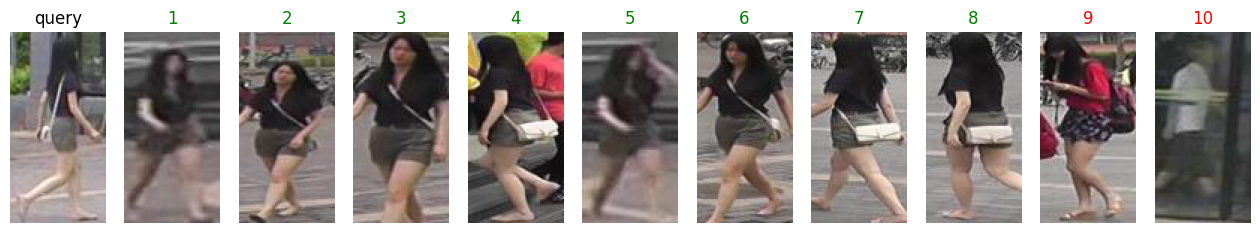

In [15]:
import matplotlib
import matplotlib.pyplot as plt

def imshow(path, title=None):
    im = plt.imread(path)
    plt.imshow(im)
    if title is not None:
        plt.title(title)
def sort_img(distmat, ql, qc, gl, gc):
    index = np.argsort(distmat)
    # index = index[::-1]
    # index = index[0:2000]
    # good index
    query_index = np.argwhere(gl==ql)
    #same camera
    camera_index = np.argwhere(gc==qc)
    #good_index = np.setdiff1d(query_index, camera_index, assume_unique=True)
    junk_index1 = np.argwhere(gl==0)
    junk_index2 = np.intersect1d(query_index, camera_index)
    junk_index = np.append(junk_index2, junk_index1)
    mask = np.in1d(index, junk_index, invert=True)
    index = index[mask]
    return index

query_index = 5
index = sort_img(distmat[query_index], q_pids[query_index], q_camids[query_index], g_pids, g_camids)

query_path = q_img_paths[query_index]
query_label = q_pids[query_index]
print('query image is:\n',query_path,'id:', query_label)
print('Top 10 images are as follow:')
fig = plt.figure(figsize=(16,4))
ax = plt.subplot(1,11,1)
ax.axis('off')
imshow(query_path,'query')
for i in range(10):
    ax = plt.subplot(1,11,i+2)
    ax.axis('off')
    img_path = g_img_paths[index[i]]
    label = g_pids[index[i]]
    if label == query_label:
        ax.set_title('%d'%(i+1), color='green')
    else:
        ax.set_title('%d'%(i+1), color='red')
    imshow(img_path)
    print(img_path, 'id:', label)
fig.savefig("show.png")
plt.show()

## 引用

[1] Liang Zheng*, Shengjin Wang, Liyue Shen*, Lu Tian*, Jiahao Bu, and Qi Tian. Person Re-identification Meets Image Search. Technical Report, 2015.

[2] Zhou K, Yang Y, Cavallaro A, et al. Omni-scale feature learning for person re-identification[C]//Proceedings of the IEEE/CVF International Conference on Computer Vision. 2019: 3702-3712.